In [2]:
%matplotlib inline

import numpy as np
import scipy

from scipy.sparse import coo_matrix, block_diag, identity, hstack, csr_matrix, csc_matrix
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import time

from pyiga import assemble, bspline, vform, geometry, vis, solvers, utils, topology, ieti, algebra, operators, adaptive
from pyiga import algebra_cy, ieti_cy

from scipy.sparse.linalg import aslinearoperator as LinOp

np.set_printoptions(linewidth=100000)
np.set_printoptions(precision=5)

In [3]:
def consistency_split(MP, a):
    patches_to_split = {}
    for (p1,b1) in MP.L_intfs:
        if len(MP.L_intfs[(p1,b1)])==2:
            p2 = MP.L_intfs[(p1,b1)][0][0]
            if a[MP.mesh.patch_domains[p1]] + 1e-3 < a[MP.mesh.patch_domains[p2]]:
                patches_to_split[p1]=None
    return patches_to_split

In [4]:
class IetiMapper:
    def __init__(self, M, dir_data, neu_data=None, elim=False):
        self.mesh = M
        self.numpatches = self.mesh.numpatches
        self.elim=bool(elim)
        self.Constr={}
        self.nConstr = 0

        self.intfs = set()
        self.L_intfs = {}

        #self.n = [tuple([kv.numdofs for kv in kvs]) for ((kvs,_),_) in self.mesh.patches]
        self.N = [np.prod([kv.numdofs for kv in kvs]) for ((kvs,_),_) in self.mesh.patches]
        self.N_ofs = np.concatenate(([0], np.cumsum(self.N)))
        self.numdofs = self.N_ofs[-1]

        for ((p1,bd1,s1),((p2,bd2,s2),flip)) in self.mesh.interfaces.items():
            if ((p2,bd2,s2),(p1,bd1,s1),flip) not in self.intfs:
                self.intfs.add(((p1,bd1,s1),(p2,bd2,s2),flip))
            
        C=[self.computeInterfaceJump(p1, (assemble.int_to_bdspec(bd1),), s1 , p2, (assemble.int_to_bdspec(bd2),), s2, flip) for ((p1,bd1,s1),(p2,bd2,s2), flip) in self.intfs.copy()]
        if len(C)!=0:
            self.B = scipy.sparse.vstack(C)

        for (p,b,_),(p2,b2,_),flip in self.intfs:
            if (p,b) not in self.L_intfs:
                self.L_intfs[(p,b)]=[(p2,b2)]
            else:
                self.L_intfs[(p,b)].append((p2,b2))

        kvs = self.mesh.kvs
        geos = self.mesh.geos

        self.dir_idx = dict()
        self.dir_vals = dict()
        self.free = [np.arange(self.N[p]) for p in range(self.numpatches)]

        for key in dir_data:
            for p,b in self.mesh.outer_boundaries[key]:
                idx_, vals_ = assemble.compute_dirichlet_bc(kvs[p], geos[p], [(b//2,b%2)], dir_data[key])
                if p in self.dir_idx:
                    self.dir_idx[p].append(idx_)
                    self.dir_vals[p].append(vals_)
                else:
                    self.dir_idx[p]=[idx_]
                    self.dir_vals[p]=[vals_]
                
        for p in self.dir_idx:
            self.dir_idx[p], lookup = np.unique(np.concatenate(self.dir_idx[p]), return_index = True)
            self.dir_vals[p] = np.concatenate(self.dir_vals[p])[lookup]
            self.free[p] = np.setdiff1d(self.free[p],self.dir_idx[p],assume_unique=True)
            
        self.global_dir_idx = np.concatenate([self.dir_idx[p] + self.N_ofs[p] for p in self.dir_idx])
        self.global_free = np.setdiff1d(np.arange(self.N_ofs[-1]),self.global_dir_idx, assume_unique=True)

        self.corners = np.concatenate([assemble.boundary_dofs(kvs,m=0,ravel=True)+self.N_ofs[p] for p, kvs in enumerate(self.mesh.kvs)])

        # if self.elim:
        #     p_intfs = np.array([[p1,p2] for (p1,_,_),(p2,_,_),_ in self.intfs], dtype=np.int32).T
        #     Basis = algebra_cy.pyx_compute_basis(B.shape[0], B.shape[1], B, maxiter=10)
        #     self.Basis, self.N_ofs, self.N, B = ieti_cy.pyx_compute_decoupled_coarse_basis(Basis.tocsc(), self.N_ofs.astype(np.int32), p_intfs)
        
        self.Bk = [self.B[:,self.N_ofs[p]:self.N_ofs[p+1]] for p in range(self.numpatches)]
        nnz_per_col = self.B.getnnz(axis=0)
        # self.intfs = np.setdiff1d(np.where(nnz_per_col > 0)[0], self.global_dir_idx)
        self.skeleton = np.setdiff1d(np.where(nnz_per_col > 0)[0], self.global_dir_idx)
        self.interior = np.setdiff1d(np.where(nnz_per_col == 0)[0], self.global_dir_idx)
        
        self.R_interior = self.numpatches*[None] ###TODO: without loops
        self.R_skeleton = self.numpatches*[None]
        self.R_interfaces = {}
        
        for p in range(self.numpatches):
            Id = scipy.sparse.eye(self.N[p], format='csr')
            mask_skeleton = np.zeros(self.N[p], dtype=bool)
            intfs = np.where(self.Bk[p].getnnz(0) > 0)[0]
            mask_interior = np.ones(self.N[p], dtype=bool)
            mask_interior[intfs]=False
            if p in self.dir_idx:
                mask_interior[self.dir_idx[p]]=False
            self.R_interior[p]=Id[mask_interior,:][:,self.free[p]]
            for b in range(4):
                if not any([(p,b) in self.mesh.outer_boundaries[key] for key in self.mesh.outer_boundaries]):
                    mask_intf = np.zeros(self.N[p], dtype=bool)
                    interface_dofs = assemble.boundary_dofs(kvs[p],bdspec=[(b//2,b%2)],ravel=True)
                    mask_intf[interface_dofs[1:-1]] = True
                    mask_skeleton[interface_dofs] = True
                    if p in self.dir_idx:
                        mask_intf[self.dir_idx[p]]=False
                        mask_skeleton[self.dir_idx[p]]=False

                    self.R_interfaces[(p,b)] = Id[mask_intf,:][:,self.free[p]]
            self.R_skeleton[p] = Id[mask_skeleton,:][:,self.free[p]]

        # self.N -= np.array([len(self.dir_idx[p]) if p in self.dir_idx else 0 for p in range(self.numpatches)])
        # self.N_ofs = np.concatenate(([0], np.cumsum(self.N)))
        # self.B = self.B[:,self.global_free]
        # self.Bk = [self.B[:,self.N_ofs[p]:self.N_ofs[p+1]] for p in range(self.numpatches)]
        
    def assemble(self, a, f):
        if self.elim:
            A = [self.Basis.T @ assemble.assemble('a * inner(grad(u), grad(v)) * dx', kvs, a=a[self.mesh.patch_domains[k]], bfuns=[('u',1), ('v',1)], geo=geo) @ self.Basis for k, ((kvs, geo),_) in enumerate(self.mesh.patches)]
            RHS = [self.Basis.T @ assemble.assemble('f * v * dx', kvs, bfuns=[('v',1)], geo=geo, f=f[self.mesh.patch_domains[k]]).ravel() for k, ((kvs, geo),_) in enumerate(self.mesh.patches)]
        else:
            A = [assemble.assemble('a * inner(grad(u), grad(v)) * dx', kvs, a=a[self.mesh.patch_domains[k]], bfuns=[('u',1), ('v',1)], geo=geo) for k, ((kvs, geo),_) in enumerate(self.mesh.patches)]
            RHS = [assemble.assemble('f * v * dx', kvs, bfuns=[('v',1)], geo=geo, f=f[self.mesh.patch_domains[k]]).ravel() for k, ((kvs, geo),_) in enumerate(self.mesh.patches)]
        
        self.BCRestr = {p:assemble.RestrictedLinearSystem(A[p], RHS[p], (self.dir_idx[p],self.dir_vals[p])) for p in self.dir_idx}
        RHS = [rhs if p not in self.dir_idx else self.BCRestr[p].b for p, rhs in enumerate(RHS)]
        A = [a if p not in self.dir_idx else self.BCRestr[p].A for p, a in enumerate(A)]

        return A, RHS

    def ConstraintMatrices(self, redundant = False):
        eliminated_constraints = np.repeat(False, self.B.shape[0])
        B = self.B.tocsc()
        if not redundant:
            eliminated_constraints = ieti_cy.eliminate_corner_constraints(B.indptr.astype(np.int32), B.indices.astype(np.int32), B.data, *B.shape, 
                                                                          self.corners.astype(np.int32), len(self.corners)).astype(bool)

        B = self.B[:,self.global_free]

        eliminated_constraints = eliminated_constraints | (B.getnnz(1)==0)
        B = B[~eliminated_constraints,:]
        ofs = np.cumsum([0]+[len(x) for x in self.free])
        return [B[:,ofs[p]:ofs[p+1]] for p in range(self.numpatches)], eliminated_constraints

    def parametersort(self, a):
        D = np.array([a[key] for key in self.mesh.patch_domains.values()], dtype=float)
        ieti_cy.pyx_parametersort(self.B.indptr, self.B.indices, self.B.data, *self.B.shape, np.repeat(D,self.N))

    def computeInterfaceJump(self, p1, bdspec1, s1, p2, bdspec2, s2, flip=None):
        """Join the dofs lying along boundary `bdspec1` of patch `p1` with
        those lying along boundary `bdspec2` of patch `p2`. 

        See :func:`compute_dirichlet_bc` for the format of the boundary
        specification.

        If `flip` is given, it should be a sequence of booleans indicating for
        each coordinate axis of the boundary if the coordinates of `p2` have to
        be flipped along that axis.
        """
        kvs1, kvs2 = self.mesh.patches[p1][0][0], self.mesh.patches[p2][0][0]
        if flip is None:
            flip=(self.sdim-1)*(False,)
        
        bkv1 = assemble.boundary_kv(kvs1, bdspec1)
        bkv2 = assemble.boundary_kv(kvs2, bdspec2, flip=flip) 
        
        #retrieve local dofs for each patch on the boundary
        dofs1 = assemble.boundary_dofs(self.mesh.patches[p1][0][0], bdspec1, ravel=True)
        dofs2 = assemble.boundary_dofs(self.mesh.patches[p2][0][0], bdspec2, ravel=True, flip=flip)
                
        #check for hierarchy of the boundary knot vectors. currently only supports knot vectors with equal degree.
        if all([bspline.is_sub_space(kv1,kv2) for kv1, kv2 in zip(bkv1,bkv2)]):
            pass
        elif all([bspline.is_sub_space(kv2,kv1) for kv1, kv2 in zip(bkv1,bkv2)]):      
            self.intfs.remove(((p1,2*bdspec1[0][0]+bdspec1[0][1],s1),(p2,2*bdspec2[0][0]+bdspec2[0][1],s2),flip))
            self.intfs.add(((p2,2*bdspec2[0][0]+bdspec2[0][1],s2),(p1,2*bdspec1[0][0]+bdspec1[0][1],s1),flip))
            p1, p2 = p2, p1
            bdspec1, bdspec2 = bdspec2, bdspec1
            bkv1, bkv2 = bkv2, bkv1
            dofs1, dofs2 = dofs2, dofs1
        else:
            #print(p1, bkv1, p2, bkv2)
            print('Interface coupling not possible between patch '+ str(p1) +' and patch '+str(p2)+'!')    

        self.Constr[(p1,p2)]=self.nConstr+np.arange(len(dofs2))
        self.nConstr+=len(dofs2)
            
        #Prolongation operator  
        P = -scipy.sparse.coo_matrix(bspline.prolongation_tp(bkv1,bkv2))   #TODO: make parameter to generate prolongation matrix as coo_matrix directly?
        
        #construct constraints for this interface
        data = np.concatenate([P.data, np.ones(len(dofs2))])
        I = np.concatenate([P.row, np.arange(len(dofs2))])
        J = np.concatenate([dofs1[P.col] + self.N_ofs[p1],dofs2 + self.N_ofs[p2]])
        A = scipy.sparse.coo_matrix((data,(I,J)),(len(dofs2), self.N_ofs[-1])).tocsr()
        return A
        
    def nodes_as_primals(self, dir_boundary=False):  ###TODO: cythonize(?)
        """Get global vertices of the multipatch object as well as local nodal degrees of freedom corresponding to the vertices. 
        In case of T-junctions also obtain the $p$ global degrees of freedom and $p$ local degrees of freedom on the coarse patch.
        Additionally may include nodes on the Dirichlet boundary if desired."""
        deg = self.mesh.patches[0][0][0][0].p
        n = self.N_ofs[-1]
        loc_c = self.corners
        if not dir_boundary: loc_c = np.setdiff1d(loc_c, self.global_dir_idx, assume_unique=True) 
  
        idx = (self.B[:,loc_c].getnnz(1)>0) & (self.B.getnnz(1)==2)
        B = self.B[idx,:]
        #B = B[B.getnnz(1)==2,:]
        loc_c = np.unique(B.indices)
        if not dir_boundary: loc_c = np.setdiff1d(loc_c, self.global_dir_idx, assume_unique=True) 

        q = np.where(B.getnnz(0)>0)[0]
        R = scipy.sparse.coo_matrix((np.ones(len(q)),(np.arange(len(q)),q)),shape=(len(q),n)).tocsr()
        c_B = B@R.T
        c_B.eliminate_zeros()

        nodal_coeff = R.T@algebra_cy.pyx_compute_basis(c_B.shape[0], c_B.shape[1], c_B, maxiter=10)
        #print(nodal_coeff)

        nodal_coeff += ieti_cy.identify_T_coefficients_from_corner_basis(nodal_coeff.indptr, nodal_coeff.indices, nodal_coeff.data, *nodal_coeff.shape, self.B.indptr,      self.B.indices,      self.B.data,       self.B.shape[0], deg)
        #nodal_coeff += ieti_cy.identify_T_coefficients_from_corner_basis(nodal_coeff.indptr, nodal_coeff.indices, nodal_coeff.data, *nodal_coeff.shape ,B.indptr, B.indices, B.data, B.shape[0], deg)
        
        #print(nodal_indicator.toarray())
        
        # dofs = np.empty(nodal_indicator.shape[1], dtype=np.int32)
        # S = c_B.sum(0).A[0]
        # for j in range(nodal_indicator.shape[1]):
        #     ind = nodal_indicator.indices[nodal_indicator.indptr[j]:nodal_indicator.indptr[j+1]]
        #     dofs[j]=R.indices[ind[np.argmax(S[ind])]]
        # nodal_indicator = (R.T@nodal_indicator)[:,nodal_indicator.getnnz(axis=0)>1]
        # nnz = self.B.getnnz(1)
        # B = self.B.tocsc()
        # constr = np.repeat(-1,len(dofs))

        # for j in range(nodal_indicator.shape[1]):
        #     dof=dofs[j]
        #     for r in range(B.indptr[dof],B.indptr[dof+1]):
        #         i=B.indices[r]
        #         if nnz[i]>2:
        #             constr[j]=i
        #             break

        # if any(constr!=-1):
        #     idx = np.where(constr!=-1)[0]
        #     res = scipy.sparse.csc_matrix(nodal_indicator.shape)
        #     Q = scipy.sparse.coo_matrix((np.ones(len(idx)),(idx,np.arange(len(idx)))),(len(constr),len(idx)))
        #     res = (Q@abs(self.B[constr[idx],:])).T
        #     res.data=res.data-1
        #     res.eliminate_zeros()
        #     res.data=res.data+1
        #     nodal_indicator += res

        # q = np.ones(self.N_ofs[-1])
        # q[self.global_dir_idx]=0
        # nodal_indicator=scipy.sparse.spdiags(q,0,self.N_ofs[-1],self.N_ofs[-1])@nodal_indicator
        # nodal_indicator = nodal_indicator[:,nodal_indicator.getnnz(0)>1]
        return nodal_coeff
        
    #def averages_as_primals(self):

    def completeDirichlet(self, U):
        return [self.BCRestr[p].complete(u) if p in self.BCRestr else u for p,u in enumerate(U)]

In [5]:
class PrimalSystem():
    def __init__(self, Prim):
        self.Prim = Prim
        self.nPrim = self.Prim.shape[1]

        self.Psi = scipy.sparse.csc_matrix((0,self.nPrim))
        self.A_prim = np.zeros(2*(self.nPrim,))
        self.RHS_prim = np.zeros(self.nPrim)
        self.R = []
        self.eliminate_pointwise = False

    def incorporate_PrimalConstraints(self, A, B, RHS, IMap, eliminate_pointwise=True):
        self.eliminate_pointwise = True
        self.nLagrangeMultipliers = B[0].shape[0]
        
        if self.nPrim == 0:
            return A, B, RHS
        K = len(A)
        self.C=[]
        
        for p in range(K):
            c = (self.Prim[IMap.N_ofs[p]:IMap.N_ofs[p+1],:].T).tocsr()
            jj = np.where((c.indptr[1:]-c.indptr[:-1])>0)[0]
            c = c[:,IMap.free[p]]
            c = c[c.getnnz(1)>0,:]
            self.C.append(c)
            self.R.append(scipy.sparse.coo_matrix((np.ones(c.shape[0]),(np.arange(c.shape[0]),jj)),(c.shape[0],self.nPrim)))
            
        self.nPrimConstr = [c.shape[0] for c in self.C]

        mod_A = [scipy.sparse.bmat([[A[p],self.C[p].T],[self.C[p], None]]) for p in range(K)]
        mod_RHS = [np.concatenate([RHS[p],np.zeros(self.nPrimConstr[p])]) for p in range(K)]

        mod_B = [scipy.sparse.hstack([B[p],scipy.sparse.csr_matrix((self.nLagrangeMultipliers, self.nPrimConstr[p]))]) for p in range(K)]
        return mod_A, mod_B, mod_RHS, self.C
        
    def compute_PrimalBasis(self, mod_A, mod_B, mod_RHS):
        #TODO: eliminate pointwise constraints if desired
        #if eliminate_pointwise:
            
        loc_solver=[solvers.make_solver(a, spd=True, symmetric=True) if self.nPrimConstr[i]==0 else solvers.make_solver(a, spd=False, symmetric=True) for i, a in enumerate(mod_A)]
        self.Psi = []
        Delta = []
        self.B_prim = np.zeros((self.nLagrangeMultipliers,self.nPrim))
        for p in range(len(mod_A)):
            RHS = scipy.sparse.vstack([scipy.sparse.csr_matrix((loc_solver[p].shape[0]-self.nPrimConstr[p],self.nPrimConstr[p])), scipy.sparse.identity(self.nPrimConstr[p])]).toarray()
            sol = loc_solver[p]@RHS
            psi, delta = sol[:(-self.nPrimConstr[p]),], sol[(-self.nPrimConstr[p]):,]
            #if psi.ndim==1: psi=psi[:,None]
            #if delta.ndim==1: delta=delta[:,None]
            Delta.append(delta)
            #print(self.C[p]@psi)
            self.Psi.append(psi@self.R[p])
            self.A_prim -= self.R[p].T@delta@self.R[p]
            self.B_prim += mod_B[p][:,:-self.nPrimConstr[p]]@self.Psi[-1]
            self.RHS_prim += self.Psi[-1].T@mod_RHS[p][:-self.nPrimConstr[p]]
        return loc_solver

    def distributePrimalSolution(self, u):
        u_prim = u[-1]
        return [u[p]+self.Psi[p]@u_prim for p in range(len(u)-1)]

    def PrimalSolution(self, u_prim):
        return [psi@u_prim for psi in self.Psi]

    # def sanity_check():
    #     assert scipy.spar
        

In [6]:
class IetiSystem():
    def __init__(self, A, B ,RHS, N, loc_solver = None, spd=False, symmetric=False):
        self.A = A
        self.B = B
        self.RHS = RHS
        self.N = N

        self.sanity_check()

        if loc_solver:
            assert len(loc_solver)==len(A), 'amount of local solvers does not match amount of local system matrices!'
            self.loc_solver=loc_solver
        else:
            self.loc_solver = [solvers.make_solver(a, spd=spd, symmetric=symmetric) for a in self.A]

        self.K = len(A)
        self.nLagrangeMultipliers = self.B[0].shape[0]

    def SaddlePointSystem(self, format='csr'):
        B = scipy.sparse.hstack(self.B)
        return scipy.sparse.bmat([[scipy.sparse.block_diag(self.A),B.T],[B,None]], format=format)

    def RHSforSaddlePointSystem(self):
        return np.concatenate(self.RHS+[np.zeros(self.nLagrangeMultipliers)])

    def SchurComplement(self, as_matrix=False):
        F = operators.SumOperator([LinOp(self.B[p])@self.loc_solver[p]@LinOp(self.B[p].T) for p in range(self.K)])
        if as_matrix:
            return F@np.identity(F.shape[1])
        return F

    def RHSforSchurComplement(self):
        return np.sum([self.B[p]@(self.loc_solver[p]@self.RHS[p]) for p in range(self.K)], axis=0)

    def constructSolutionFromLagrangeMultipliers(self, lam):
        return [(self.loc_solver[p]@(self.RHS[p]-self.B[p].T@lam))[:self.N[p]] for p in range(self.K)]
        
    def sanity_check(self):
        assert len(A)==len(B)==len(RHS), 'Length of input data incompatible!'
        K = len(A)
        assert np.all([B[0].shape[0]==B[p].shape[0] for p in range(K)]), 'Constraint matrices have incompatible number of constraints!'
        assert np.all([self.A[p].shape[0]==self.A[p].shape[1] for p in range(K)]), 'Local system matrices are not square!'
        assert np.all([self.B[p].shape[1] == self.A[p].shape[1] for p in range(K)]), 'Constraint matrices have incompatible dimension!'
        assert np.all([self.A[p].shape[0]==len(self.RHS[p]) for p in range(K)]), 'Local rhs vectors have incompatible dimension!'

In [7]:
class ScaledDirichletPreconditioner():
    def __init__(self, A ,B, IMap):
        self.A = A
        self.IMap = IMap
        self.K   = len(B)

        self.B = [B[p]@IMap.R_skeleton[p].T for p in range(self.K)]
        self.B_full   = scipy.sparse.hstack(self.B, format='csr')
        self.BN  = np.array([IMap.R_skeleton[p].shape[0] for p in range(self.K)]) 
        self.BN_ofs = np.cumsum(np.r_[0,self.BN])

        self.D = []
        self.S = [LinOp(IMap.R_skeleton[p]@A[p]@IMap.R_skeleton[p].T) - 
                  LinOp(IMap.R_skeleton[p]@A[p]@IMap.R_interior[p].T)
                  @solvers.make_solver(IMap.R_interior[p]@A[p]@IMap.R_interior[p].T, spd=True)
                  @LinOp(IMap.R_interior[p]@A[p].T@IMap.R_skeleton[p].T) for p in range(self.K)]

    def SchurMatrices(self): #for large number of degrees of freedom not feasible
        return [s@np.eye(s.shape[0]) for s in self.S]

    def setupMultiplicityScaling(self):
        d = ieti_cy.pyx_multiplicity_scaling(self.B_full.indptr, self.B_full.indices, self.B_full.data, *self.B_full.shape)
        self.D = [scipy.sparse.diags(d[self.BN_ofs[p]:self.BN_ofs[p+1]], format='csr') for p in range(self.K)] 
        
    # def setupConstraintScaling(self):
    #     d = ieti_cy.pyx_constraint_scaling(self.B_full.indptr, self.B_full.indices, self.B_full.data, *self.B_full.shape)
    #     self.D = [scipy.sparse.diags(d[self.BN_ofs[p]:self.BN_ofs[p+1]], format='csr') for p in range(self.K)] 

    def setupWeightScaling(self):
        d = ieti_cy.pyx_weight_scaling(self.B_full.indptr, self.B_full.indices, self.B_full.data, *self.B_full.shape)
        self.D = [scipy.sparse.diags(d[self.BN_ofs[p]:self.BN_ofs[p+1]], format='csr') for p in range(self.K)] 
        
    def setupCoefficientScaling(self, a):  ###TODO: cythonize
        self.D = [scipy.sparse.csr_matrix((self.B[p].shape[1],self.B[p].shape[1])) for p in range(self.K)]
        for (p1,b1) in self.IMap.L_intfs:
            R1 = self.IMap.R_interfaces[(p1,b1)]@self.IMap.R_skeleton[p1].T
            for (p2,b2) in self.IMap.L_intfs[(p1,b1)]:
                R2 = self.IMap.R_interfaces[(p2,b2)]@self.IMap.R_skeleton[p2].T
                a1, a2 = a[self.IMap.mesh.patch_domains[p1]], a[self.IMap.mesh.patch_domains[p2]]
                self.D[p1] += (a2)/(a1+a2)*R1.T@scipy.sparse.identity(R1.shape[0])@R1
                self.D[p2] += (a1)/(a1+a2)*R2.T@scipy.sparse.identity(R2.shape[0])@R2
        
    def setupSelectionScaling(self):
        d = ieti_cy.pyx_selection_scaling(self.B_full.indptr, self.B_full.indices, self.B_full.data, *self.B_full.shape)
        self.D = [scipy.sparse.diags(d[self.BN_ofs[p]:self.BN_ofs[p+1]], format='csr') for p in range(self.K)] 

    def setupDeluxeScaling(self):  ###TODO: cythonize and/or write it as solution of sparse systems (no computation of Schur matrices)
        self.D = [np.zeros((self.B[p].shape[1],self.B[p].shape[1])) for p in range(self.K)]
        S = self.SchurMatrices()
        for (p1,b1) in self.IMap.L_intfs:
            R1 = self.IMap.R_interfaces[(p1,b1)]@self.IMap.R_skeleton[p1].T
            S1 = R1@S[p1]@R1.T
            for (p2,b2) in self.IMap.L_intfs[(p1,b1)]:
                R2 = self.IMap.R_interfaces[(p2,b2)]@self.IMap.R_skeleton[p2].T
                S2 = R2@S[p2]@R2.T
                Inv = np.linalg.inv(S1+S2)
                self.D[p1]+=R1.T@(Inv@S2)@R1
                self.D[p2]+=R2.T@(Inv@S1)@R2
        
    def prec(self):
        assert len(self.D)==self.K, 'Not all scaling matrices given! Call a setup routine first!'
        self.BgD = [LinOp(self.B[p]@self.D[p]) for p in range(self.K)]
        B = scipy.sparse.hstack(self.B)
        print("Convergence condition: {:.3}".format(scipy.sparse.linalg.norm(B@scipy.sparse.block_diag(self.D).T@B.T@B-B))) #check Algebraic condition
        return operators.SumOperator([self.BgD[p]@self.S[p]@self.BgD[p].T for p in range(self.K)])     

In [8]:
def MsD_deluxe_whole(IMap, S, B, C):
    S_ = [np.zeros(s.shape) for s in S]
    B_ = len(B)*[None]
    C_ = len(C)*[None]
    for p in range(IMap.numpatches):
        C_[p]=C[p]@IMap.R_skeleton[p].T
        B_[p] = scipy.sparse.hstack([B[p],scipy.sparse.csr_matrix((B[p].shape[0],C_[p].shape[0]))])
        for b in range(4):
            if (p,b) in IMap.R_interfaces:
                R = IMap.R_interfaces[(p,b)]@IMap.R_skeleton[p].T
                S_[p] += R.T@R@S[p]@R.T@R
        #print(S_[p].shape, C_[p].shape)
    return np.linalg.pinv(np.array([B_[p]@np.linalg.inv(scipy.sparse.block_array([[S_[p],C_[p].T],[C_[p],np.zeros(2*(C_[p].shape[0],))]]).toarray())@B_[p].T for p in range(len(S))]).sum(axis=0))

setting up constraints took 0.008363008499145508 seconds.
Basis setup took 0.0031290054321289062 seconds
Setting up Mapper took 0.01772332191467285 seconds.
Assembling took 0.024262428283691406 seconds.
Computing jump matrices took 0.0005643367767333984 seconds.
Setting up primal system took 0.0014767646789550781 seconds.
Setting up primal constraints took 0.0030508041381835938 seconds.
Setting up primal basis and local solvers took 0.0037126541137695312 seconds.
Setting up Schur system took 0.0007884502410888672 seconds.


pcg with preconditioned condition number κ ~ 3.398 stopped after 8 iterations with relres 4.943e-08 after 0.0021 seconds.
#############################################################################################
Setting up multiplicity scaling took 0.0008411407470703125 seconds.
Convergence condition: 0.645
pcg with preconditioned condition number κ ~ 1.735e+03 stopped after 3 iterations with relres 6.561e-11 after 0.00275 seconds.
##############################

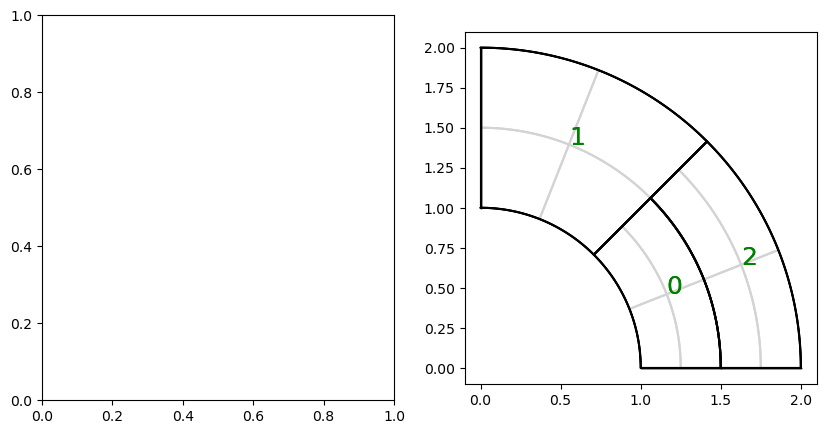

In [22]:
deg = 1
N = 2

knots = (bspline.make_knots(deg,0,1,N),bspline.make_knots(deg,0,1,N))
M = topology.PatchMesh([(knots,geometry.quarter_annulus())])
M.h_refine({0:0});
M.h_refine({0:1});
#M.h_refine();

#M.h_refine({1:1})
M.set_domain_id({1:{1}, 2:{2}})
#M.h_refine({0:-1});
#M.h_refine({2:1})

f={0:lambda x,y: 100., 1:lambda x,y: 100., 2:lambda x,y: 100.}
#idx=np.random.permutation(np.arange(4))
#idx=np.arange(4)
idx = [0,1,2]
values = [1,1e4, 1]

a = {idx[0]:values[0],idx[1]:values[1], idx[2]:values[2]}
#a = {0:1., 1:1e6, 2:1e4}
dir_data = {0:0}

MP = assemble.Multipatch(M, automatch=True)
marked_patches = {0}
# while len(marked_patches)>0:
#     marked_patches = consistency_split(MP,a)
#     print(marked_patches)
#     M.h_refine(patches=marked_patches,ref="rs");
#     MP = assemble.Multipatch(M, automatch=True)
fig ,ax = plt.subplots(1, 2, figsize=(10, 5))
M.plotmesh(knots=1, patch_idx=1, axis=ax[0])#, color={0:'yellow', 1:'blue', 2:'red', 3:'green'})
M.plotmesh(knots=1, patch_idx=1, axis=ax[1])
#plt.colorbar(label='Intensity')

t = time.time()
IMap = IetiMapper(M, dir_data)
IMap.parametersort(a)
print('Setting up Mapper took '+str(time.time()-t)+' seconds.')
t =time.time()
A, RHS = IMap.assemble(a,f)
print('Assembling took '+str(time.time()-t)+' seconds.')
N = [a.shape[0] for a in A]
t=time.time()
B, eliminated_constraints = IMap.ConstraintMatrices(redundant=False)
print('Computing jump matrices took '+str(time.time()-t)+' seconds.')

P = ScaledDirichletPreconditioner(A, B, IMap)

t=time.time()
primal = PrimalSystem(IMap.nodes_as_primals())
print('Setting up primal system took '+str(time.time()-t)+' seconds.')
t=time.time()
A, B, RHS, C = primal.incorporate_PrimalConstraints(A, B, RHS, IMap)
print('Setting up primal constraints took '+str(time.time()-t)+' seconds.')
t=time.time()
loc_solver = primal.compute_PrimalBasis(A, B, RHS)
print('Setting up primal basis and local solvers took '+str(time.time()-t)+' seconds.')
A.append(primal.A_prim), B.append(primal.B_prim), RHS.append(primal.RHS_prim), 
loc_solver.append(solvers.make_solver(primal.A_prim, symmetric=True, spd=True)), N.append(primal.A_prim.shape[0])

t=time.time()
I = IetiSystem(A, B, RHS, N, loc_solver)
F, b = I.SchurComplement(), I.RHSforSchurComplement()
print('Setting up Schur system took '+str(time.time()-t)+' seconds.')

#F_mat = F@np.eye(F.shape[0])

print('\n')

lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=1000, P=1, output=True, rtol=1e-6, atol=1e-12)
print('#############################################################################################')

t=time.time()
P.setupMultiplicityScaling()
print('Setting up multiplicity scaling took '+str(time.time()-t)+' seconds.')
lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=P.prec(), output=True, rtol=1e-6, atol=1e-12)
print('#############################################################################################')


# t=time.time()
# P.setupWeightScaling()
# print('Setting up weight scaling took '+str(time.time()-t)+' seconds.')
# lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=P.prec(), output=True, rtol=1e-6, atol=1e-12)
# print('#############################################################################################')

t=time.time()
P.setupCoefficientScaling(a)
print('Setting up coefficient scaling took '+str(time.time()-t)+' seconds.')
lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=P.prec(), output=True, rtol=1e-6, atol=1e-12)
print('#############################################################################################')

# t=time.time()
# P.setupDeluxeScaling()
# print('Setting up deluxe scaling took '+str(time.time()-t)+' seconds.')
# lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=P.prec(), output=True, rtol=1e-6, atol=1e-12)
# print('#############################################################################################')

t=time.time()
P.setupSelectionScaling()
print('Setting up selection scaling took '+str(time.time()-t)+' seconds.')
lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=P.prec(), output=True, rtol=1e-6, atol=1e-12)
print('#############################################################################################')

# t=time.time()
# Prec = MsD_deluxe_whole(IMap, P.SchurMatrices(), P.B, C)
# print('Setting up edge scaling took '+str(time.time()-t)+' seconds.')
# lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=Prec, output=True, rtol=1e-6, atol=1e-12)
# print('#############################################################################################')

u_delta = I.constructSolutionFromLagrangeMultipliers(lam)[:-1]
u_prim =primal.PrimalSolution(I.constructSolutionFromLagrangeMultipliers(lam)[-1])

u_delta = np.concatenate(IMap.completeDirichlet(u_delta))
u_prim = np.concatenate(IMap.completeDirichlet(u_prim))

# MP.plot(u_delta)
# MP.plot(u_prim)
#MP.plot(u_delta+u_prim, axis=ax[1])
plt.axis('scaled');
plt.show()

In [27]:
eliminated_constraints

array([ True, False,  True,  True, False,  True,  True, False,  True])

In [38]:
print(IMap.B[8,:])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2 stored elements and shape (1, 27)>
  Coords	Values
  (0, 8)	-1.0
  (0, 24)	1.0


In [130]:
B, eliminated_constraints = IMap.ConstraintMatrices(redundant=False)

In [135]:
B[1].toarray()

array([[-0.5,  0. ],
       [-1. ,  0. ],
       [-1. ,  0. ],
       [-0.5,  0. ],
       [ 0. ,  0. ]])

In [26]:
P.D[0].toarray()

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

In [14]:
a

{0: 1, 1: 1, 2: 1, 3: 1}

In [101]:
%timeit IMap.nodes_as_primals()

2.27 ms ± 61.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [72]:
print(nodal_coeff)

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 7 stored elements and shape (45, 2)>
  Coords	Values
  (36, 0)	1.0
  (20, 0)	1.0
  (7, 0)	1.0
  (27, 1)	1.0
  (15, 1)	1.0
  (38, 1)	1.0
  (8, 1)	1.0


In [228]:
loc_c = np.setdiff1d(IMap.corners, IMap.global_dir_idx)

In [231]:
(IMap.B[:,loc_c]).getnnz(1)==2

array([False, False,  True,  True, False, False,  True, False, False, False, False,  True])

In [203]:
IMap.B[:,[8,15,20,27]].toarray()

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [-1.,  1.,  0.,  0.],
       [ 0.,  0., -1.,  1.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  1.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [-1.,  0.,  1.,  0.]])

In [126]:
print(IMap.nodes_as_primals()[:,1])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5 stored elements and shape (125, 1)>
  Coords	Values
  (23, 0)	0.5000000000000002
  (24, 0)	1.5
  (45, 0)	1.0
  (75, 0)	1.0
  (104, 0)	1.0


In [97]:
p=0
primal.C[p]@primal.Psi[p]
#np.linalg.norm(scipy.sparse.identity(primal.C[p].shape[0])-primal.C[p]@primal.Psi[p])

array([[0., 1.]])

In [85]:
print(primal.C[p])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1 stored elements and shape (1, 16)>
  Coords	Values
  (0, 0)	1.0


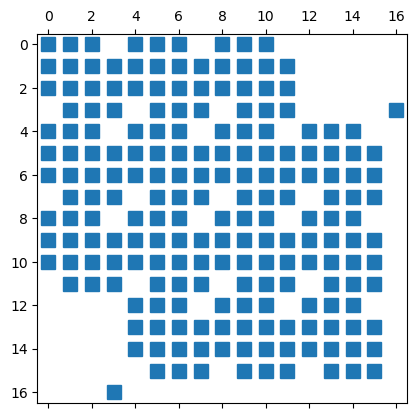

In [73]:
plt.spy(A[p])

In [60]:
primal.C

[<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 1 stored elements and shape (1, 100)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 1 stored elements and shape (1, 100)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 1 stored elements and shape (1, 100)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 1 stored elements and shape (1, 100)>]

In [52]:
primal.B_prim

array([[ 2.25477e-03],
       [ 3.98322e-03],
       [ 1.30922e-02],
       [ 1.54967e-02],
       [ 3.36191e-02],
       [ 3.47627e-02],
       [ 5.47642e-02],
       [ 3.22755e-02],
       [ 4.82855e-02],
       [ 4.77530e-02],
       [ 3.09848e-02],
       [ 5.47885e-02],
       [ 3.42497e-02],
       [ 3.37106e-02],
       [ 1.52896e-02],
       [ 1.31826e-02],
       [ 3.90592e-03],
       [ 2.27612e-03],
       [-1.67530e-03],
       [-1.29474e-03],
       [-8.51556e-04],
       [-6.86933e-04],
       [-4.09823e-04],
       [-2.87089e-04],
       [-1.42718e-04],
       [-8.23285e-05],
       [-2.35740e-05],
       [-2.95625e-07],
       [-9.82194e-07],
       [-1.72616e-06],
       [-3.20065e-06],
       [-4.56426e-06],
       [-7.17205e-06],
       [-8.90648e-06],
       [-1.28600e-05],
       [-1.63737e-05]])

In [36]:
ieti_cy.pyx_parametersort()

TypeError: pyx_parametersort() takes exactly 6 positional arguments (0 given)

In [24]:
M.

{0: {np.int64(0)}, 1: {1}, 2: {2, 3}}

In [11]:
B = scipy.sparse.hstack(P.B)

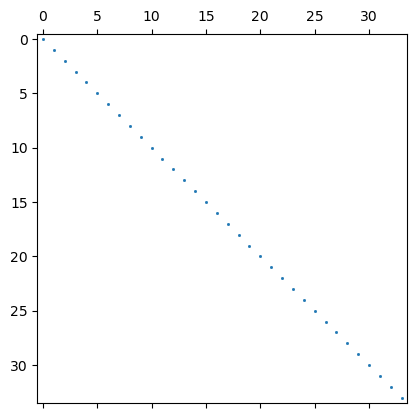

In [12]:
plt.spy(B@scipy.sparse.block_diag(P.D).T@B.T, markersize=1)

In [233]:
primal.A_prim.shape

(14, 14)

In [186]:
np.linalg.eig(primal.A_prim)

EigResult(eigenvalues=array([-1.16468e+08, -8.33325e+07,  5.06057e+05,  1.26055e+04,  1.10134e+02,  1.22617e+00,  3.44564e+00,  1.84939e+00,  2.76316e+00]), eigenvectors=array([[ 1.93732e-10, -6.74282e-11,  2.88755e-08, -2.34337e-06, -3.47056e-04, -4.72012e-01, -6.74743e-01,  5.51720e-01, -1.32404e-01],
       [ 2.67711e-01, -3.16238e-01, -1.68312e-01, -2.45304e-03,  8.94382e-01, -5.38128e-03,  4.85929e-03,  2.67282e-03,  3.21368e-03],
       [ 2.67738e-01,  3.16194e-01, -1.81165e-01,  8.91918e-01,  1.30851e-05, -1.61514e-05, -1.20287e-06, -1.20431e-05, -2.33348e-06],
       [ 5.32234e-01,  1.50204e-05,  8.46510e-01,  1.21686e-02,  3.04479e-05, -5.88629e-07, -8.92248e-08, -4.76994e-07,  4.55732e-07],
       [ 1.94105e-09, -3.20462e-09,  2.80876e-07,  1.65228e-07, -8.64999e-03, -4.57015e-01,  7.13026e-01,  5.13805e-01,  1.36604e-01],
       [ 5.89812e-11,  9.72462e-11,  1.47762e-08, -1.74295e-05,  2.91460e-05, -5.26886e-01,  1.29187e-01, -4.61264e-01, -7.02095e-01],
       [-5.35422e-01

In [95]:
cmap(norm(values[3]))

(np.float64(0.993248),
 np.float64(0.906157),
 np.float64(0.143936),
 np.float64(1.0))

In [9]:
def EdgePreconditioner(IMap, S, B):
    B_red, eliminated = IMap.ConstraintMatrices(redundant=True)
    B_red = [b[:,b.getnnz(0)>0] for b in B_red]
    MsD = np.zeros((B[0].shape[0],B[0].shape[0]))
    for (p1,b1) in IMap.L_intfs:
        R1 = IMap.R_interfaces[(p1,b1)]@IMap.R_skeleton[p1].T
        S1_inv = np.linalg.inv(R1@S[p1]@R1.T)
        for (p2,b2) in IMap.L_intfs[(p1,b1)]:
            R2 = IMap.R_interfaces[(p2,b2)]@IMap.R_skeleton[p2].T
            S2_inv=np.linalg.inv(R2@S[p2]@R2.T)
            B2 = B[p2]@R2.T
            B1 = B_red[p1]@R1.T
            B1 = B1[(B_red[p2]@R2.T).getnnz(1)>0,:]
            MsD+=B2@(S2_inv + B1@S1_inv@B1.T)@B2.T
    return MsD

# Checkerboard mesh with jumping coefficients (larger coefficient has coarser grid)

In [211]:
degs = (3,)
maxiter=3 ##<8
R = np.zeros((maxiter,2*len(degs)))

f={0:lambda x,y: 100., 1:lambda x,y: 100.}
a = {0:1.,1:1000.}
dir_data = {0:0}

plot=False

for i,deg in enumerate(degs):
    N = deg+1
    knots = (bspline.make_knots(deg,0,1,N),bspline.make_knots(deg,0,1,N))
    M = topology.PatchMesh([(knots,geometry.quarter_annulus())])
    M.h_refine()
    M.h_refine()
    M.set_domain_id({1:{0,1,2,3,6,9,12,15}})
    #M.h_refine({p:-1 for p in {0,1,2,3,6,9,12,15}})
    M.h_refine({p:-1 for p in {4,5,7,8,10,11,13,14}})

    MP = assemble.Multipatch(M, automatch=True)

    print("======================================================")
    print("deg = "+str(deg))
    for k in range(maxiter):
        print("Iteration {}".format(k))
        if plot:
            M.draw(figsize=(3,3),color={1:'orange',0:'white'}, knots=1, bwidth=0.01, nodes=0)
            plt.axis('off');
            plt.axis('scaled');
            #plt.savefig('/home/wolfman/Pictures/Inductor/p'+str(deg)+'/i'+str(i)+'.pdf',bbox_inches='tight');
            plt.show()

        MP = assemble.Multipatch(M, automatch=True)

        t_IETI = 0
        ### IETI Mapper
        t = time.time()
        IMap = IetiMapper(M, dir_data)
        IMap.parametersort(a)
        print("Setting up IETI-mapper took {:.3} seconds.".format(time.time()-t))
        t=time.time()
        A, RHS = IMap.assemble(a=a,f=f)
        print("Assembling the system took {:.3} seconds.".format(time.time()-t))
        N = [A.shape[0] for A in A]

        B, eliminated_constraints = IMap.ConstraintMatrices(redundant=True)
        I = IetiSystem(A, B, RHS, N)

        A_full = I.SaddlePointSystem(format='csc')
        RHS_full = I.RHSforSaddlePointSystem()
        eps=1e-6

        z = np.zeros(A_full.shape[0])
        z[-B[0].shape[0]:]=eps
        A_full += scipy.sparse.spdiags(z,0,*A_full.shape)
    
        t=time.time()
        B, eliminated_constraints = IMap.ConstraintMatrices(redundant=False)
        print("Computing jump matrices took {:.3} seconds.".format(time.time()-t))
        ### IETI Preconditioner
        SD = ScaledDirichletPreconditioner(A, B, IMap)

        t=time.time()

        ### Set up primal system
        t=time.time()
        primal = PrimalSystem(IMap.nodes_as_primals())
        t_IETI+=time.time()-t
        print("Setting up primal system took {:.3} seconds.".format(time.time()-t))
        t=time.time()
        A, B, RHS, C = primal.incorporate_PrimalConstraints(A, B, RHS, IMap)
        t_IETI+=time.time()-t
        print("Setting up primal constraints took {:.3} seconds.".format(time.time()-t))

        t=time.time()
        loc_solver = primal.compute_PrimalBasis(A, B, RHS)
        t_IETI+=time.time()-t
        print("Computing primal basis took {:.3} seconds.".format(time.time()-t))
        A.append(primal.A_prim), B.append(primal.B_prim), RHS.append(primal.RHS_prim), loc_solver.append(solvers.make_solver(primal.A_prim, spd=True, symmetric=True)), N.append(primal.A_prim.shape[0])

        ### Set up IETI Schur System and solve with CG
        I = IetiSystem(A, B, RHS, N, loc_solver)
        t=time.time()
        F, b = I.SchurComplement(), I.RHSforSchurComplement()
        t_IETI+=time.time()-t
        print("Setting up Schur complements took {:.3} seconds.".format(time.time()-t))

        t=time.time()
        SD.setupSelectionScaling(a=a)
        t_IETI+=time.time()-t
        print("Setting up selection scaling took {:.3} seconds.".format(time.time()-t))
        #P = MsD_deluxe_whole(IMap, SD.SchurMatrices(), SD.B, C)

        t=time.time()
        U = solvers.make_solver(A_full, symmetric=True)@RHS_full
        print("Solving full system took {:.3} seconds.".format(time.time()-t))
        
        lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=SD.prec(), output=True, rtol=1e-6, atol=1e-12)
        R[k,2*i] = abs(max_eig/min_eig)
        R[k,2*i+1] = it 

        ### Construct Solution from Lagrange Multiplier and complete with Dirichlet values
        t=time.time()
        u = primal.distributePrimalSolution(I.constructSolutionFromLagrangeMultipliers(lam))
        u = np.concatenate([IMap.BCRestr[p].complete(u) if p in IMap.BCRestr else u for p,u in enumerate(u)])
        t_IETI+=time.time()-t
        print("Computing full solution from skeleton took {:.3} seconds.".format(time.time()-t))
        print("Full time for the IETI-solver: {:.3} seconds".format(t_IETI))
        #print(len(u))
        #MP.plot(u)

        #err_ind=adaptive.mp_resPois(MP,u,a=a, f=f)

        #marked_patches = adaptive.doerfler_mark(err_ind, theta=0.9, TOL=0)
        #marked_patches = {p:None for p in marked_patches}

        M.h_refine(-1);

        print("#####################################################")
#np.savetxt('checkerboard_badselection.txt', R, fmt=len(degs)*('%1.3f','%d'), delimiter = ' & ', newline='\\\\\n')

setting up constraints took 0.044449806213378906 seconds.
Basis setup took 0.0037283897399902344 seconds
deg = 3
Iteration 0
setting up constraints took 0.03508329391479492 seconds.
Basis setup took 0.002425670623779297 seconds
Setting up IETI-mapper took 0.0799 seconds.
Assembling the system took 0.16 seconds.
Computing jump matrices took 0.00101 seconds.
Setting up primal system took 0.00251 seconds.
Setting up primal constraints took 0.0152 seconds.
Computing primal basis took 0.0264 seconds.
Setting up Schur complements took 0.00194 seconds.
Setting up selection scaling took 0.0047 seconds.
Solving full system took 0.00481 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 1.013 stopped after 3 iterations with relres 1.519e-08 after 0.0138 seconds.
Computing full solution from skeleton took 0.00214 seconds.
Full time for the IETI-solver: 0.0529 seconds
#####################################################
Iteration 1
setting up constraints took 0.03532

In [34]:
def Heat_annulus(deg, N):
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.quarter_annulus(),
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)

    M.h_refine()

    M.set_domain_id({1:{0}})
    return M

setting up constraints took 0.011634349822998047 seconds.
Basis setup took 0.0031998157501220703 seconds
deg = 3
0


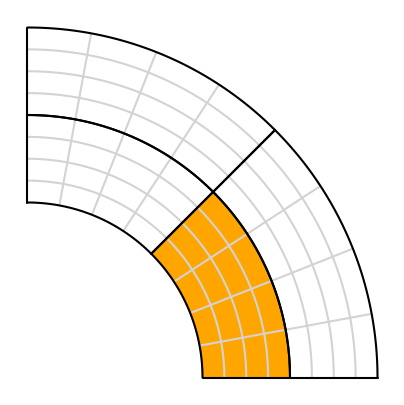

setting up constraints took 0.0060384273529052734 seconds.
Basis setup took 0.0019192695617675781 seconds
Setting up IETI-mapper took 0.0209 seconds.
Assembling the system took 0.0469 seconds.
Computing jump matrices took 0.000532 seconds.
Setting up primal system took 0.00266 seconds.
Setting up primal constraints took 0.00403 seconds.
Computing primal basis took 0.00617 seconds.
Setting up Schur complements took 0.00241 seconds.
Setting up selection scaling took 0.00243 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 3.678 stopped after 7 iterations with relres 3.616e-08 after 0.00629 seconds.
Residual contributions took 0.0324 seconds.
Jump contributions took 0.0258 seconds.
Estimating and marking took 0.0583 seconds.
setting up constraints took 0.02698969841003418 seconds.
Basis setup took 0.002353191375732422 seconds
Patch-splitting took 0.039 seconds for 3 patches
setting up constraints took 0.031195878982543945 seconds.
Basis setup took 0.0022842

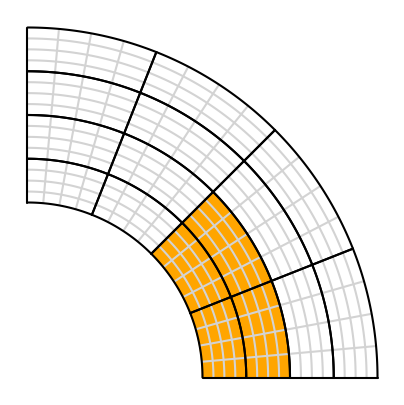

setting up constraints took 0.034909725189208984 seconds.
Basis setup took 0.0026514530181884766 seconds
Setting up IETI-mapper took 0.0756 seconds.
Assembling the system took 0.181 seconds.
Computing jump matrices took 0.00123 seconds.
Setting up primal system took 0.00261 seconds.
Setting up primal constraints took 0.014 seconds.
Computing primal basis took 0.0247 seconds.
Setting up Schur complements took 0.00169 seconds.
Setting up selection scaling took 0.00791 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 9.435 stopped after 16 iterations with relres 8.478e-07 after 0.0452 seconds.
Residual contributions took 0.116 seconds.
Jump contributions took 0.155 seconds.
Estimating and marking took 0.272 seconds.
setting up constraints took 0.06221914291381836 seconds.
Basis setup took 0.0029790401458740234 seconds
Patch-splitting took 0.0781 seconds for 3 patches
setting up constraints took 0.06798124313354492 seconds.
Basis setup took 0.002436399459838

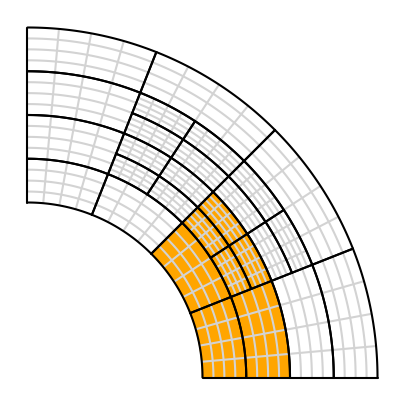

setting up constraints took 0.07046175003051758 seconds.
Basis setup took 0.002658367156982422 seconds
Setting up IETI-mapper took 0.138 seconds.
Assembling the system took 0.255 seconds.
Computing jump matrices took 0.00172 seconds.
Setting up primal system took 0.00316 seconds.
Setting up primal constraints took 0.0241 seconds.
Computing primal basis took 0.0443 seconds.
Setting up Schur complements took 0.00308 seconds.
Setting up selection scaling took 0.014 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 10.55 stopped after 20 iterations with relres 6.118e-07 after 0.0971 seconds.
Residual contributions took 0.208 seconds.
Jump contributions took 0.332 seconds.
Estimating and marking took 0.54 seconds.
setting up constraints took 0.0963752269744873 seconds.
Basis setup took 0.002914905548095703 seconds
Patch-splitting took 0.113 seconds for 3 patches
setting up constraints took 0.10457491874694824 seconds.
Basis setup took 0.0032532215118408203 sec

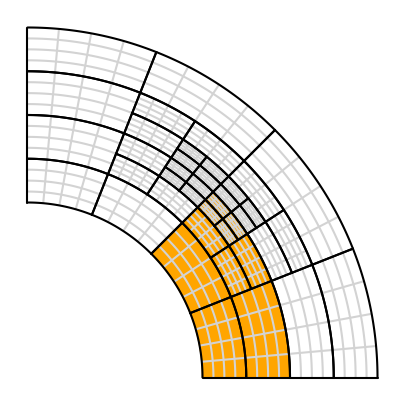

setting up constraints took 0.1052541732788086 seconds.
Basis setup took 0.0034873485565185547 seconds
Setting up IETI-mapper took 0.184 seconds.
Assembling the system took 0.352 seconds.
Computing jump matrices took 0.00244 seconds.
Setting up primal system took 0.00337 seconds.
Setting up primal constraints took 0.0337 seconds.
Computing primal basis took 0.0644 seconds.
Setting up Schur complements took 0.0047 seconds.
Setting up selection scaling took 0.02 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.3 stopped after 21 iterations with relres 5.48e-07 after 0.173 seconds.
Residual contributions took 0.303 seconds.
Jump contributions took 0.519 seconds.
Estimating and marking took 0.822 seconds.
setting up constraints took 0.13243532180786133 seconds.
Basis setup took 0.0031173229217529297 seconds
Patch-splitting took 0.152 seconds for 3 patches
setting up constraints took 0.14180517196655273 seconds.
Basis setup took 0.0034220218658447266 secon

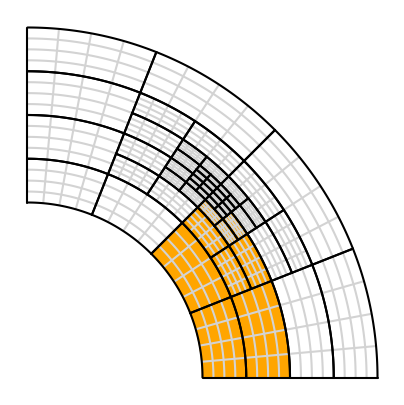

setting up constraints took 0.14336657524108887 seconds.
Basis setup took 0.003902912139892578 seconds
Setting up IETI-mapper took 0.247 seconds.
Assembling the system took 0.463 seconds.
Computing jump matrices took 0.00289 seconds.
Setting up primal system took 0.00373 seconds.
Setting up primal constraints took 0.068 seconds.
Computing primal basis took 0.0955 seconds.
Setting up Schur complements took 0.00642 seconds.
Setting up selection scaling took 0.0271 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.46 stopped after 21 iterations with relres 9.593e-07 after 0.2 seconds.
Residual contributions took 0.402 seconds.
Jump contributions took 0.694 seconds.
Estimating and marking took 1.1 seconds.
setting up constraints took 0.1760263442993164 seconds.
Basis setup took 0.0034284591674804688 seconds
Patch-splitting took 0.203 seconds for 4 patches
setting up constraints took 0.1777477264404297 seconds.
Basis setup took 0.0034112930297851562 seconds

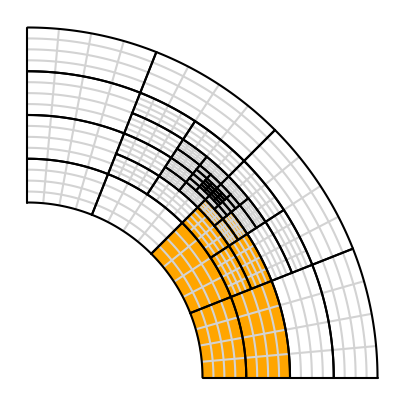

setting up constraints took 0.17704319953918457 seconds.
Basis setup took 0.003777027130126953 seconds
Setting up IETI-mapper took 0.296 seconds.
Assembling the system took 0.553 seconds.
Computing jump matrices took 0.0034 seconds.
Setting up primal system took 0.00363 seconds.
Setting up primal constraints took 0.0539 seconds.
Computing primal basis took 0.108 seconds.
Setting up Schur complements took 0.00742 seconds.
Setting up selection scaling took 0.0331 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.54 stopped after 22 iterations with relres 5.114e-07 after 0.244 seconds.
Residual contributions took 0.49 seconds.
Jump contributions took 0.872 seconds.
Estimating and marking took 1.36 seconds.
setting up constraints took 0.23802876472473145 seconds.
Basis setup took 0.004082202911376953 seconds
Patch-splitting took 0.285 seconds for 7 patches
setting up constraints took 0.24328088760375977 seconds.
Basis setup took 0.004305124282836914 second

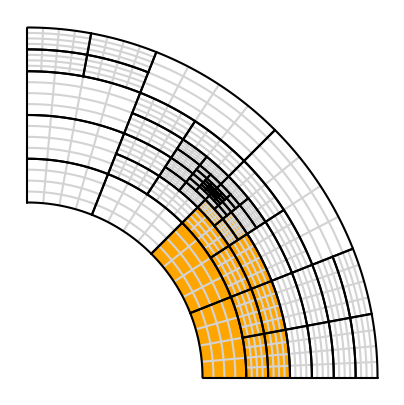

setting up constraints took 0.24253630638122559 seconds.
Basis setup took 0.004214048385620117 seconds
Setting up IETI-mapper took 0.404 seconds.
Assembling the system took 0.747 seconds.
Computing jump matrices took 0.0047 seconds.
Setting up primal system took 0.00415 seconds.
Setting up primal constraints took 0.0791 seconds.
Computing primal basis took 0.151 seconds.
Setting up Schur complements took 0.00964 seconds.
Setting up selection scaling took 0.047 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.47 stopped after 22 iterations with relres 8.458e-07 after 0.35 seconds.
Residual contributions took 0.69 seconds.
Jump contributions took 1.19 seconds.
Estimating and marking took 1.88 seconds.
setting up constraints took 0.2926464080810547 seconds.
Basis setup took 0.0043354034423828125 seconds
Patch-splitting took 0.34 seconds for 6 patches
setting up constraints took 0.2920553684234619 seconds.
Basis setup took 0.004323482513427734 seconds
###

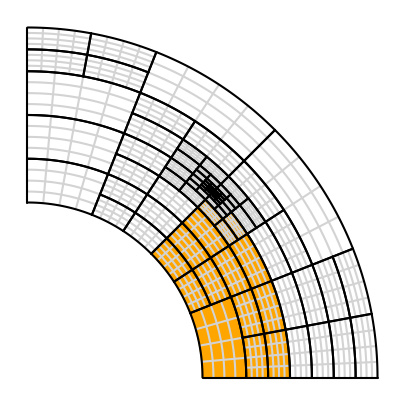

setting up constraints took 0.28846287727355957 seconds.
Basis setup took 0.004427194595336914 seconds
Setting up IETI-mapper took 0.487 seconds.
Assembling the system took 0.885 seconds.
Computing jump matrices took 0.00628 seconds.
Setting up primal system took 0.00428 seconds.
Setting up primal constraints took 0.0932 seconds.
Computing primal basis took 0.187 seconds.
Setting up Schur complements took 0.0121 seconds.
Setting up selection scaling took 0.0555 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.43 stopped after 22 iterations with relres 8.606e-07 after 0.444 seconds.
Residual contributions took 0.81 seconds.
Jump contributions took 1.43 seconds.
Estimating and marking took 2.24 seconds.
setting up constraints took 0.33938097953796387 seconds.
Basis setup took 0.004785776138305664 seconds
Patch-splitting took 0.392 seconds for 6 patches
setting up constraints took 0.34031224250793457 seconds.
Basis setup took 0.004708528518676758 seconds

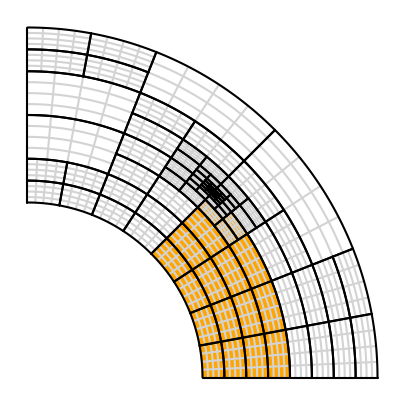

setting up constraints took 0.33829283714294434 seconds.
Basis setup took 0.0048067569732666016 seconds
Setting up IETI-mapper took 0.568 seconds.
Assembling the system took 1.05 seconds.
Computing jump matrices took 0.00721 seconds.
Setting up primal system took 0.0045 seconds.
Setting up primal constraints took 0.107 seconds.
Computing primal basis took 0.229 seconds.
Setting up Schur complements took 0.0147 seconds.
Setting up selection scaling took 0.0653 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.41 stopped after 22 iterations with relres 9.468e-07 after 0.526 seconds.
Residual contributions took 0.93 seconds.
Jump contributions took 1.65 seconds.
Estimating and marking took 2.58 seconds.
setting up constraints took 0.40761303901672363 seconds.
Basis setup took 0.0051059722900390625 seconds
Patch-splitting took 0.482 seconds for 8 patches
setting up constraints took 0.4089326858520508 seconds.
Basis setup took 0.005195140838623047 seconds
#

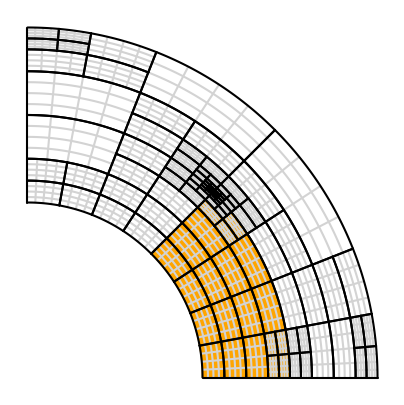

setting up constraints took 0.40571141242980957 seconds.
Basis setup took 0.0052890777587890625 seconds
Setting up IETI-mapper took 0.679 seconds.
Assembling the system took 1.26 seconds.
Computing jump matrices took 0.00927 seconds.
Setting up primal system took 0.00517 seconds.
Setting up primal constraints took 0.126 seconds.
Computing primal basis took 0.283 seconds.
Setting up Schur complements took 0.0175 seconds.
Setting up selection scaling took 0.0808 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.42 stopped after 22 iterations with relres 9.675e-07 after 0.655 seconds.
Residual contributions took 1.12 seconds.
Jump contributions took 2.0 seconds.
Estimating and marking took 3.12 seconds.
setting up constraints took 0.4930908679962158 seconds.
Basis setup took 0.005587577819824219 seconds
Patch-splitting took 0.576 seconds for 8 patches
setting up constraints took 0.48033881187438965 seconds.
Basis setup took 0.006272315979003906 seconds
##

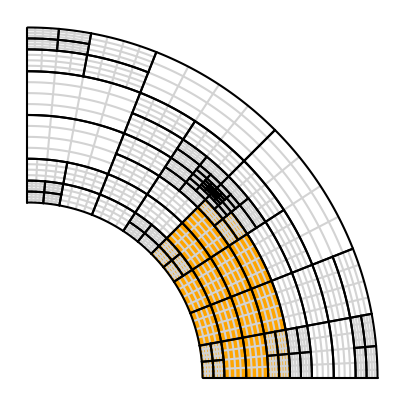

setting up constraints took 0.4760863780975342 seconds.
Basis setup took 0.005279541015625 seconds
Setting up IETI-mapper took 0.786 seconds.
Assembling the system took 1.44 seconds.
Computing jump matrices took 0.0107 seconds.
Setting up primal system took 0.00514 seconds.
Setting up primal constraints took 0.146 seconds.
Computing primal basis took 0.347 seconds.
Setting up Schur complements took 0.0204 seconds.
Setting up selection scaling took 0.0958 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.54 stopped after 23 iterations with relres 5.384e-07 after 0.797 seconds.
Residual contributions took 1.32 seconds.
Jump contributions took 2.34 seconds.
Estimating and marking took 3.65 seconds.
setting up constraints took 0.5740766525268555 seconds.
Basis setup took 0.005995273590087891 seconds
Patch-splitting took 0.706 seconds for 12 patches
setting up constraints took 0.5805990695953369 seconds.
Basis setup took 0.006213188171386719 seconds
#######

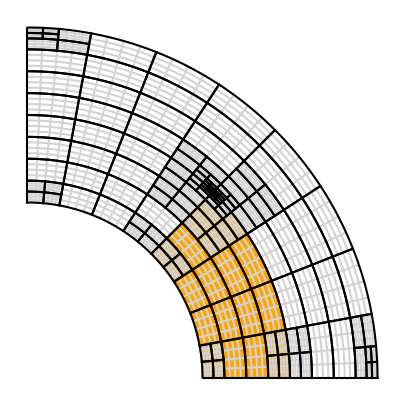

setting up constraints took 0.5762896537780762 seconds.
Basis setup took 0.005841255187988281 seconds
Setting up IETI-mapper took 0.956 seconds.
Assembling the system took 1.78 seconds.
Computing jump matrices took 0.0138 seconds.
Setting up primal system took 0.00559 seconds.
Setting up primal constraints took 0.181 seconds.
Computing primal basis took 0.46 seconds.
Setting up Schur complements took 0.0485 seconds.
Setting up selection scaling took 0.13 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.71 stopped after 23 iterations with relres 5.465e-07 after 1.37 seconds.
Residual contributions took 1.62 seconds.
Jump contributions took 2.84 seconds.
Estimating and marking took 4.46 seconds.
setting up constraints took 0.6788270473480225 seconds.
Basis setup took 0.006502389907836914 seconds
Patch-splitting took 0.851 seconds for 12 patches
setting up constraints took 0.6853423118591309 seconds.
Basis setup took 0.00668025016784668 seconds
#########

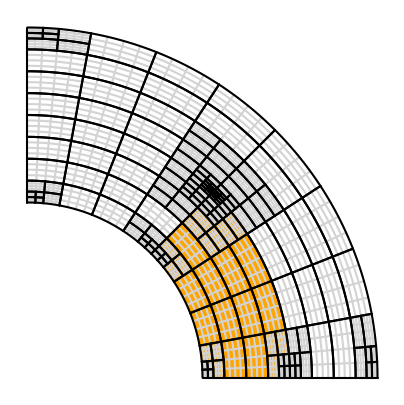

setting up constraints took 0.6847994327545166 seconds.
Basis setup took 0.0066683292388916016 seconds
Setting up IETI-mapper took 1.13 seconds.
Assembling the system took 2.15 seconds.
Computing jump matrices took 0.0173 seconds.
Setting up primal system took 0.00609 seconds.
Setting up primal constraints took 0.218 seconds.
Computing primal basis took 0.712 seconds.
Setting up Schur complements took 0.0496 seconds.
Setting up selection scaling took 0.157 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.86 stopped after 23 iterations with relres 6.149e-07 after 1.72 seconds.
Residual contributions took 1.91 seconds.
Jump contributions took 3.36 seconds.
Estimating and marking took 5.28 seconds.
setting up constraints took 0.8101165294647217 seconds.
Basis setup took 0.0073969364166259766 seconds
Patch-splitting took 1.02 seconds for 15 patches
setting up constraints took 0.8150522708892822 seconds.
Basis setup took 0.00730443000793457 seconds
#######

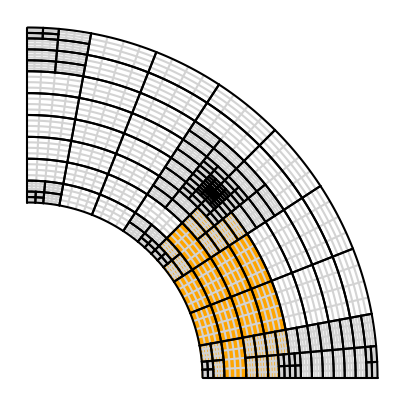

setting up constraints took 0.8123087882995605 seconds.
Basis setup took 0.007274627685546875 seconds
Setting up IETI-mapper took 1.35 seconds.
Assembling the system took 2.52 seconds.
Computing jump matrices took 0.0224 seconds.
Setting up primal system took 0.00664 seconds.
Setting up primal constraints took 0.262 seconds.
Computing primal basis took 1.2 seconds.
Setting up Schur complements took 0.0531 seconds.
Setting up selection scaling took 0.187 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.61 stopped after 22 iterations with relres 9.808e-07 after 1.89 seconds.
Residual contributions took 2.26 seconds.
Jump contributions took 4.0 seconds.
Estimating and marking took 6.26 seconds.
setting up constraints took 1.0114843845367432 seconds.
Basis setup took 0.008549213409423828 seconds
Patch-splitting took 1.39 seconds for 23 patches
setting up constraints took 1.0378077030181885 seconds.
Basis setup took 0.008541345596313477 seconds
###########

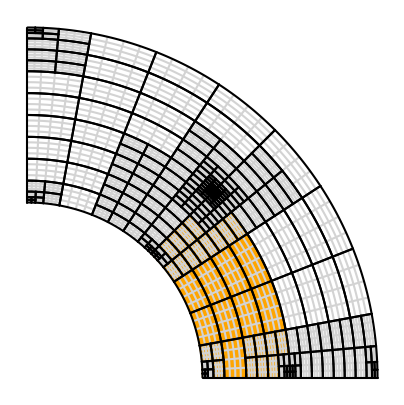

setting up constraints took 1.0283763408660889 seconds.
Basis setup took 0.008501529693603516 seconds
Setting up IETI-mapper took 1.71 seconds.
Assembling the system took 3.18 seconds.
Computing jump matrices took 0.0317 seconds.
Setting up primal system took 0.00753 seconds.
Setting up primal constraints took 0.329 seconds.
Computing primal basis took 2.22 seconds.
Setting up Schur complements took 0.0759 seconds.
Setting up selection scaling took 0.238 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 12.2 stopped after 23 iterations with relres 6.373e-07 after 2.42 seconds.
Residual contributions took 2.84 seconds.
Jump contributions took 5.07 seconds.
Estimating and marking took 7.91 seconds.


/home/wolfman/miniforge3/lib/python3.12/site-packages/pyiga/bspline.py:833: MatrixRankWarning: Matrix is exactly singular
  P = scipy.sparse.linalg.spsolve(C2,C1)


298 (KnotVector(array([0.5    , 0.5    , 0.5    , 0.5    , 0.50001, 0.50002, 0.50002, 0.50003, 0.50003, 0.50003, 0.50003]), 3),) 376 (KnotVector(array([0.5    , 0.5    , 0.5    , 0.5    , 0.50002, 0.50002, 0.50002, 0.50002]), 3),)
interface coupling not possible
299 (KnotVector(array([0.5    , 0.5    , 0.5    , 0.5    , 0.50001, 0.50002, 0.50002, 0.50003, 0.50003, 0.50003, 0.50003]), 3),) 377 (KnotVector(array([0.5    , 0.5    , 0.5    , 0.5    , 0.50002, 0.50002, 0.50002, 0.50002]), 3),)
interface coupling not possible
307 (KnotVector(array([0.49997, 0.49997, 0.49997, 0.49997, 0.49998, 0.49998, 0.49999, 0.5    , 0.5    , 0.5    , 0.5    ]), 3),) 309 (KnotVector(array([0.49997, 0.49997, 0.49997, 0.49997, 0.49998, 0.49998, 0.49998, 0.49998]), 3),)
interface coupling not possible
312 (KnotVector(array([0.49997, 0.49997, 0.49997, 0.49997, 0.49998, 0.49998, 0.49999, 0.5    , 0.5    , 0.5    , 0.5    ]), 3),) 400 (KnotVector(array([0.49997, 0.49997, 0.49997, 0.49997, 0.49998, 0.49998, 0.499

AssertionError: Not an H^1-conforming function space.

In [49]:
f={0:lambda x,y: 100., 1:lambda x,y: 100.}
a = {0:1.,1:1000.}
dir_data = {0:0}

plot=True

degs = (3,)
maxiter=15
R = np.zeros((maxiter,3*len(degs)))
for i,deg in enumerate(degs):
    N = deg+1
    M = Heat_annulus(deg,N)
    MP = assemble.Multipatch(M, automatch=True)

    print("======================================================")
    print("deg = "+str(deg))
    for k in range(maxiter):
        print(k)
        n_p = MP.numpatches
        if plot:
            M.draw(figsize=(5,5),color={1:'orange',0:'white'}, knots=1, bwidth=0.01, nodes=0)
            plt.axis('off');
            plt.axis('scaled');
            #plt.savefig('/home/wolfman/Pictures/Inductor/p'+str(deg)+'/i'+str(i)+'.pdf',bbox_inches='tight');
            plt.show()

        MP = assemble.Multipatch(M, automatch=True)

        ### IETI Mapper
        t = time.time()
        IMap = IetiMapper(M, dir_data)
        IMap.parametersort(a)
        print("Setting up IETI-mapper took {:.3} seconds.".format(time.time()-t))
        t=time.time()
        A, RHS = IMap.assemble(a=a,f=f)
        print("Assembling the system took {:.3} seconds.".format(time.time()-t))
        N = [A.shape[0] for A in A]
        t=time.time()
        B, eliminated_constraints = IMap.ConstraintMatrices(redundant=False)
        print("Computing jump matrices took {:.3} seconds.".format(time.time()-t))
        ### IETI Preconditioner
        SD = ScaledDirichletPreconditioner(A, B, IMap)

        ### Set up primal system
        t=time.time()
        primal = PrimalSystem(IMap.nodes_as_primals())
        print("Setting up primal system took {:.3} seconds.".format(time.time()-t))
        t=time.time()
        A, B, RHS, C = primal.incorporate_PrimalConstraints(A, B, RHS, IMap)
        print("Setting up primal constraints took {:.3} seconds.".format(time.time()-t))

        t=time.time()
        loc_solver = primal.compute_PrimalBasis(A, B, RHS)
        print("Computing primal basis took {:.3} seconds.".format(time.time()-t))
        A.append(primal.A_prim), B.append(primal.B_prim), RHS.append(primal.RHS_prim), loc_solver.append(solvers.make_solver(primal.A_prim, spd=True, symmetric=True)), N.append(primal.A_prim.shape[0])

        ### Set up IETI Schur System and solve with CG
        I = IetiSystem(A, B, RHS, N, loc_solver)
        t=time.time()
        F, b = I.SchurComplement(), I.RHSforSchurComplement()
        print("Setting up Schur complements took {:.3} seconds.".format(time.time()-t))

        #lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=1, output=True, rtol=1e-6, atol=1e-12)

        t=time.time()
        SD.setupSelectionScaling(a=a)
        print("Setting up selection scaling took {:.3} seconds.".format(time.time()-t))
        #P = MsD_deluxe_whole(IMap, SD.SchurMatrices(), SD.B, C)
        #A_full = I.SaddlePointSystem(format='csc')
        #RHS_full = I.RHSforSaddlePointSystem()

        # t=time.time()
        # U = solvers.make_solver(A_full)@RHS_full
        # print("Solving full system took {:.3} seconds.".format(time.time()-t))
        
        lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=SD.prec(), output=True, rtol=1e-6, atol=1e-12)
        R[k,3*i] = n_p
        R[k,3*i+1] = abs(max_eig/min_eig)
        R[k,3*i+2] = it 

        ### Construct Solution from Lagrange Multiplier and complete with Dirichlet values
        u = primal.distributePrimalSolution(I.constructSolutionFromLagrangeMultipliers(lam))
        u = np.concatenate([IMap.BCRestr[p].complete(u) if p in IMap.BCRestr else u for p,u in enumerate(u)])
        #MP.plot(u)

        t=time.time()
        err_ind=adaptive.mp_resPois(MP,u,a=a, f=f)

        marked_patches = adaptive.quick_mark(err_ind, theta=0.9)
        marked_patches = {p:None for p in marked_patches}
        print("Estimating and marking took {:.3} seconds.".format(time.time()-t))

        t=time.time()
        M.h_refine(patches=marked_patches,ref="rs");
        MP = assemble.Multipatch(M, automatch=True)
        print("Patch-splitting took {:.3} seconds for {} patches".format(time.time()-t, len(marked_patches)))

        marked_patches = consistency_split(MP,a)
        #print(marked_patches)
        M.h_refine(patches=marked_patches,ref="rs");
        MP = assemble.Multipatch(M, automatch=True)

        print("#####################################################")

#np.savetxt('singular_selection_consistency', R, fmt=len(degs)*('%d', '%1.3f','%d'), delimiter = ' & ', newline='\\\\\n')

In [50]:
def Inductor(deg,N, airgap=0.025):
    kvs=42*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    
    geos=[      
        geometry.unit_square().scale((0.5)).translate((-0.5,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,-0.5)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,-0.5)),
        geometry.unit_square().scale(0.5).translate((1.5,-0.5)),
        
        geometry.unit_square().scale((0.5,0.25)).translate((-0.5,0)),
        geometry.unit_square().scale(0.25),
        geometry.unit_square().scale(0.25).translate((0.25,0)),
        geometry.unit_square().scale((0.5,0.25)).translate((0.5,0)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.,0)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.25,0)),
        geometry.unit_square().scale((0.5,0.25)).translate((1.5,0)),
        
        geometry.unit_square().scale((0.5,airgap)).translate((-0.5,0.25)),
        geometry.unit_square().scale((0.25,airgap)).translate((0,0.25)),
        geometry.unit_square().scale((0.25,airgap)).translate((0.25,0.25)),
        geometry.unit_square().scale((0.5,airgap)).translate((0.5,0.25)),
        geometry.unit_square().scale((0.25,airgap)).translate((1.,0.25)),
        geometry.unit_square().scale((0.25,airgap)).translate((1.25,0.25)),
        geometry.unit_square().scale((0.5,airgap)).translate((1.5,0.25)),
        
        geometry.unit_square().scale((0.5,0.5)).translate((-0.5,0.25+airgap)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,0.25+airgap)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,0.25+airgap)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,0.25+airgap)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,0.25+airgap)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,0.25+airgap)),
        geometry.unit_square().scale((0.5,0.5)).translate((1.5,0.25+airgap)),
        
        geometry.unit_square().scale((0.5,0.25)).translate((-0.5,0.75+airgap)),
        geometry.unit_square().scale((0.25,0.25)).translate((0,0.75+airgap)),
        geometry.unit_square().scale((0.25,0.25)).translate((0.25,0.75+airgap)),
        geometry.unit_square().scale((0.5,0.25)).translate((0.5,0.75+airgap)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.,0.75+airgap)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.25,0.75+airgap)),
        geometry.unit_square().scale((0.5,0.25)).translate((1.5,0.75+airgap)),
        
        geometry.unit_square().scale(0.5).translate((-0.5,1.0+airgap)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,1.0+airgap)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,1.0+airgap)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,1.0+airgap)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,1.0+airgap)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,1.0+airgap)),
        geometry.unit_square().scale(0.5).translate((1.5,1.0+airgap)),
         ]
    patches=list(zip(kvs,geos))
    M = topology.PatchMesh(patches)
    M.rename_domain(0,'Air')
    M.set_domain_id({'Fe':{8,9,10,11,12,22,24,26,29,30,31,32,33}, 'C1':{23}, 'C2':{25}})
    return M

In [51]:
mu0 = 4*np.pi*1e-7
nu = {'C1': 1/mu0, 'C2':1/mu0, 'Fe':1/(2500*mu0), 'Air': 1/mu0}
#nu = {'C1': 1., 'C2':1., 'Fe':1., 'Air': 1.}
j = {'C1': lambda x,y: 66/(0.125), 'C2':lambda x,y: -66/(0.125), 'Fe':lambda x,y: 0.0, 'Air': lambda x,y: 0.0}
MaT = {'C1': lambda x,y: (0.,0.), 'C2': lambda x,y:(0.,0.), 'Fe':lambda x,y:(0.,0.), 'Air': lambda x,y:(0.,0.)}
dir_data = {0:0}

setting up constraints took 0.09274578094482422 seconds.
Basis setup took 0.0029714107513427734 seconds
deg = 3
0


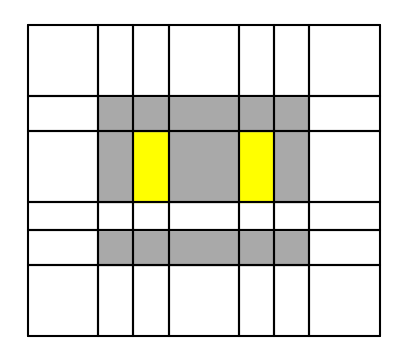

setting up constraints took 0.09328413009643555 seconds.
Basis setup took 0.002782106399536133 seconds
Setting up IETI-mapper took 0.187 seconds.
Assembling the system took 0.336 seconds.
Computing jump matrices took 0.00297 seconds.
Setting up primal system took 0.00378 seconds.
Setting up primal constraints took 0.0368 seconds.
Computing primal basis took 0.106 seconds.
Setting up Schur complements took 0.0113 seconds.
Setting up selection scaling took 0.00878 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 9.077 stopped after 15 iterations with relres 6.808e-07 after 0.111 seconds.
Residual contributions took 0.242 seconds.
Jump contributions took 0.373 seconds.
Estimating and marking took 0.615 seconds.
setting up constraints took 0.20197081565856934 seconds.
Basis setup took 0.0040111541748046875 seconds
Patch-splitting took 0.267 seconds for 12 patches
{22: None, 10: None, 30: None, 26: None, 8: None, 32: None, 12: None}
setting up constraints too

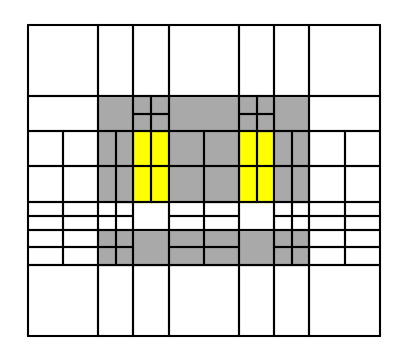

setting up constraints took 0.26146697998046875 seconds.
Basis setup took 0.004740476608276367 seconds
Setting up IETI-mapper took 0.45 seconds.
Assembling the system took 0.743 seconds.
Computing jump matrices took 0.00566 seconds.
Setting up primal system took 0.003 seconds.
Setting up primal constraints took 0.0845 seconds.
Computing primal basis took 0.183 seconds.
Setting up Schur complements took 0.0104 seconds.
Setting up selection scaling took 0.0191 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.55 stopped after 20 iterations with relres 7.777e-07 after 0.361 seconds.
Residual contributions took 0.598 seconds.
Jump contributions took 1.29 seconds.
Estimating and marking took 1.89 seconds.
setting up constraints took 0.46601009368896484 seconds.
Basis setup took 0.005255937576293945 seconds
Patch-splitting took 0.642 seconds for 22 patches
{87: None, 22: None, 91: None, 98: None, 11: None, 9: None}
setting up constraints took 0.5093083381652

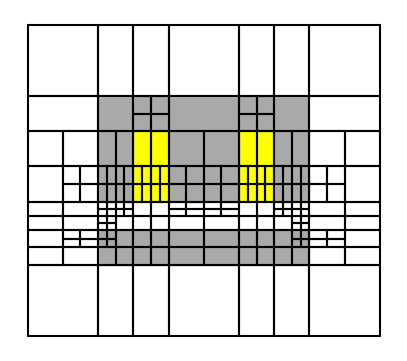

setting up constraints took 0.5046954154968262 seconds.
Basis setup took 0.005492448806762695 seconds
Setting up IETI-mapper took 0.84 seconds.
Assembling the system took 1.41 seconds.
Computing jump matrices took 0.0112 seconds.
Setting up primal system took 0.00572 seconds.
Setting up primal constraints took 0.155 seconds.
Computing primal basis took 0.378 seconds.
Setting up Schur complements took 0.0208 seconds.
Setting up selection scaling took 0.0356 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 10.44 stopped after 21 iterations with relres 7.969e-07 after 0.981 seconds.
Residual contributions took 1.08 seconds.
Jump contributions took 2.52 seconds.
Estimating and marking took 3.6 seconds.
setting up constraints took 0.742393970489502 seconds.
Basis setup took 0.010647058486938477 seconds
Patch-splitting took 1.05 seconds for 26 patches
{165: None, 26: None, 162: None, 172: None, 176: None, 22: None}
setting up constraints took 0.793698787689209

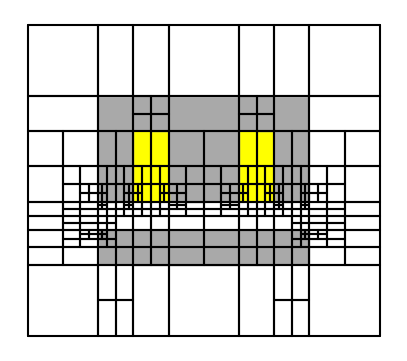

setting up constraints took 0.7902781963348389 seconds.
Basis setup took 0.007220268249511719 seconds
Setting up IETI-mapper took 1.28 seconds.
Assembling the system took 2.1 seconds.
Computing jump matrices took 0.0186 seconds.
Setting up primal system took 0.011 seconds.
Setting up primal constraints took 0.241 seconds.
Computing primal basis took 0.94 seconds.
Setting up Schur complements took 0.0606 seconds.
Setting up selection scaling took 0.0691 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.46 stopped after 22 iterations with relres 6.888e-07 after 1.99 seconds.
Residual contributions took 1.58 seconds.
Jump contributions took 3.84 seconds.
Estimating and marking took 5.42 seconds.
setting up constraints took 1.0417444705963135 seconds.
Basis setup took 0.008875131607055664 seconds
Patch-splitting took 1.43 seconds for 26 patches
{275: None, 261: None, 267: None, 26: None, 22: None, 271: None}
setting up constraints took 1.093883991241455 se

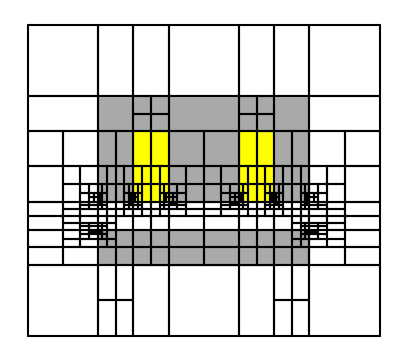

setting up constraints took 1.0969386100769043 seconds.
Basis setup took 0.00883340835571289 seconds
Setting up IETI-mapper took 1.77 seconds.
Assembling the system took 2.82 seconds.
Computing jump matrices took 0.0305 seconds.
Setting up primal system took 0.0195 seconds.
Setting up primal constraints took 0.326 seconds.
Computing primal basis took 2.26 seconds.
Setting up Schur complements took 0.0854 seconds.
Setting up selection scaling took 0.0828 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.37 stopped after 22 iterations with relres 6.805e-07 after 2.38 seconds.
Residual contributions took 2.12 seconds.
Jump contributions took 5.35 seconds.
Estimating and marking took 7.47 seconds.
setting up constraints took 1.3544983863830566 seconds.
Basis setup took 0.010125398635864258 seconds
Patch-splitting took 1.89 seconds for 29 patches
{96: None, 363: None, 8: None, 373: None, 22: None, 360: None, 26: None, 359: None}
setting up constraints took 

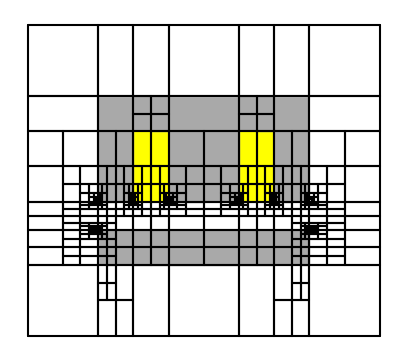

setting up constraints took 1.4316487312316895 seconds.
Basis setup took 0.010458946228027344 seconds
Setting up IETI-mapper took 2.28 seconds.
Assembling the system took 3.65 seconds.
Computing jump matrices took 0.0454 seconds.
Setting up primal system took 0.032 seconds.
Setting up primal constraints took 0.426 seconds.
Computing primal basis took 4.5 seconds.
Setting up Schur complements took 0.116 seconds.
Setting up selection scaling took 0.113 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.4 stopped after 22 iterations with relres 6.961e-07 after 3.06 seconds.
Residual contributions took 2.75 seconds.
Jump contributions took 6.83 seconds.
Estimating and marking took 9.58 seconds.
setting up constraints took 1.754124641418457 seconds.
Basis setup took 0.012219429016113281 seconds
Patch-splitting took 2.49 seconds for 32 patches
{462: None, 485: None, 26: None, 22: None, 472: None, 465: None, 477: None, 8: None}
setting up constraints took 1.79

In [53]:
degs = (3,)
maxiter=6
R = np.zeros((maxiter,4*len(degs)))
for i,deg in enumerate(degs):
    N = deg+1
    M = Inductor(deg,N, airgap=0.2)
    MP = assemble.Multipatch(M, automatch=True)

    print("======================================================")
    print("deg = "+str(deg))
    for k in range(maxiter):
        print(k)
        n_p = MP.numpatches
        M.draw(figsize=(5,5),color={'C1':'yellow', 'C2':'yellow', 'Fe':'darkgrey', 'Air':'white'}, knots=0, bwidth=0.01, patch_idx=0)
        plt.axis('off');
        plt.axis('scaled');
        #plt.savefig('/home/wolfman/Pictures/Inductor/p'+str(deg)+'/i'+str(i)+'.pdf',bbox_inches='tight');
        plt.show()

        MP = assemble.Multipatch(M, automatch=True)

        ### IETI Mapper
        t = time.time()
        IMap = IetiMapper(M, dir_data)
        IMap.parametersort(nu)
        print("Setting up IETI-mapper took {:.3} seconds.".format(time.time()-t))
        t=time.time()
        A, RHS = IMap.assemble(a=nu,f=j)
        print("Assembling the system took {:.3} seconds.".format(time.time()-t))
        N = [A.shape[0] for A in A]
        t=time.time()
        B, eliminated_constraints = IMap.ConstraintMatrices(redundant=False)
        print("Computing jump matrices took {:.3} seconds.".format(time.time()-t))
        ### IETI Preconditioner
        SD = ScaledDirichletPreconditioner(A, B, IMap)

        ### Set up primal system
        t=time.time()
        primal = PrimalSystem(IMap.nodes_as_primals())
        print("Setting up primal system took {:.3} seconds.".format(time.time()-t))
        t=time.time()
        A, B, RHS, C = primal.incorporate_PrimalConstraints(A, B, RHS, IMap)
        print("Setting up primal constraints took {:.3} seconds.".format(time.time()-t))

        t=time.time()
        loc_solver = primal.compute_PrimalBasis(A, B, RHS)
        print("Computing primal basis took {:.3} seconds.".format(time.time()-t))
        A.append(primal.A_prim), B.append(primal.B_prim), RHS.append(primal.RHS_prim), loc_solver.append(solvers.make_solver(primal.A_prim, spd=True, symmetric=True)), N.append(primal.A_prim.shape[0])

        ### Set up IETI Schur System and solve with CG
        I = IetiSystem(A, B, RHS, N, loc_solver)
        t=time.time()
        F, b = I.SchurComplement(), I.RHSforSchurComplement()
        print("Setting up Schur complements took {:.3} seconds.".format(time.time()-t))

        #lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=1, output=True, rtol=1e-6, atol=1e-12)

        t=time.time()
        SD.setupSelectionScaling()
        print("Setting up selection scaling took {:.3} seconds.".format(time.time()-t))
        #P = MsD_deluxe_whole(IMap, SD.SchurMatrices(), SD.B, C)
        #A_full = I.SaddlePointSystem(format='csc')
        #RHS_full = I.RHSforSaddlePointSystem()

        # t=time.time()
        # U = solvers.make_solver(A_full)@RHS_full
        # print("Solving full system took {:.3} seconds.".format(time.time()-t))
        
        lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=2000, P=SD.prec(), output=True, rtol=1e-6, atol=1e-12)
        R[k,3*i] = n_p
        R[k,3*i+1] = abs(max_eig/min_eig)
        R[k,3*i+2] = it 

        ### Construct Solution from Lagrange Multiplier and complete with Dirichlet values
        u = primal.distributePrimalSolution(I.constructSolutionFromLagrangeMultipliers(lam))
        u = np.concatenate([IMap.BCRestr[p].complete(u) if p in IMap.BCRestr else u for p,u in enumerate(u)])
        #MP.plot(u)

        t=time.time()
        err_ind=adaptive.mp_resPois(MP,u,a=nu, f=j, M=MaT)

        marked_patches = adaptive.quick_mark(err_ind, theta=0.95)
        marked_patches = {p:None for p in marked_patches}
        print("Estimating and marking took {:.3} seconds.".format(time.time()-t))

        t=time.time()
        M.h_refine(patches=marked_patches,ref="rs");
        MP = assemble.Multipatch(M, automatch=True)
        print("Patch-splitting took {:.3} seconds for {} patches".format(time.time()-t, len(marked_patches)))

        marked_patches = {0}
        while len(marked_patches)>0:
            marked_patches = consistency_split(MP,nu)
            print(marked_patches)
            M.h_refine(patches=marked_patches,ref="rs");
            MP = assemble.Multipatch(M, automatch=True)

        print("#####################################################")

In [143]:
M = Inductor(deg,N, airgap=0.2)
#MP = assemble.Multipatch(M, automatch=True)

In [144]:
M.h_refine({10:None, 17:None, 24:None})

{10: (10, 42, 43, 44), 17: (17, 45, 46, 47), 24: (24, 48, 49, 50)}

In [147]:
IMap = IetiMapper(M, dir_data)
IMap.parametersort(nu)
A, RHS = IMap.assemble(a=nu,f=j)
N = [A.shape[0] for A in A]
B, eliminated_constraints = IMap.ConstraintMatrices(redundant=False)
SD = ScaledDirichletPreconditioner(A, B, IMap)
SD.setupSelectionScaling()

In [148]:
SD.setupSelectionScaling()

In [151]:
print(M.patch_domains)

{0: 'Air', 1: 'Air', 2: 'Air', 3: 'Air', 4: 'Air', 5: 'Air', 6: 'Air', 7: 'Air', 8: 'Fe', 9: 'Fe', 10: 'Fe', 11: 'Fe', 12: 'Fe', 13: 'Air', 14: 'Air', 15: 'Air', 16: 'Air', 17: 'Air', 18: 'Air', 19: 'Air', 20: 'Air', 21: 'Air', 22: 'Fe', 23: 'C1', 24: 'Fe', 25: 'C2', 26: 'Fe', 27: 'Air', 28: 'Air', 29: 'Fe', 30: 'Fe', 31: 'Fe', 32: 'Fe', 33: 'Fe', 34: 'Air', 35: 'Air', 36: 'Air', 37: 'Air', 38: 'Air', 39: 'Air', 40: 'Air', 41: 'Air', 42: 'Fe', 43: 'Fe', 44: 'Fe', 45: 'Air', 46: 'Air', 47: 'Air', 48: 'Fe', 49: 'Fe', 50: 'Fe'}


In [152]:
SD.D[8]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 27 stored elements and shape (40, 40)>

In [16]:
def Heat_annulus(deg, N):
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.quarter_annulus(),
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)

    M.h_refine()

    M.set_domain_id({1:{0}})
    return M

In [25]:
f={0:lambda x,y: 100., 1:lambda x,y: 100.}
a = {0:1.,1:1e4}
dir_data = {0:0}

In [79]:
degs = (2,3,5,8)
maxiter=10
R = np.zeros((maxiter,4*len(degs)))
for i,deg in enumerate(degs):
    N = deg+1
    M = Heat_annulus(deg,N)
    MP = assemble.Multipatch(M, automatch=True)

    print("======================================================")
    print("deg = "+str(deg))
    for k in range(maxiter):
        print(k)
        #n_p = MP.numpatches
        # M.draw(figsize=(5,5),color={1:'yellow',0:'white'}, knots=1, bwidth=0.01, patch_idx=1)
        # plt.axis('off');
        # plt.axis('scaled');
        # #plt.savefig('/home/wolfman/Pictures/Inductor/p'+str(deg)+'/i'+str(i)+'.pdf',bbox_inches='tight');
        # plt.show()

        MP = assemble.Multipatch(M, automatch=True)

        ### IETI Mapper
        IMap = IetiMapper(M, dir_data)
        A, RHS = IMap.assemble(a=a,f=f)
        N = [A.shape[0] for A in A]
        B, eliminated_constraints = IMap.ConstraintMatrices(redundant=False)

        ### IETI Preconditioner
        SD = ScaledDirichletPreconditioner(A, B, IMap)

        ### Set up primal system
        primal = PrimalSystem(IMap.nodes_as_primals())
        A, B, RHS, C = primal.incorporate_PrimalConstraints(A, B, RHS, IMap)
        
        loc_solver = primal.compute_PrimalBasis(A, B, RHS)
        A.append(primal.A_prim), B.append(primal.B_prim), RHS.append(primal.RHS_prim), loc_solver.append(solvers.make_solver(primal.A_prim, spd=True, symmetric=True)), N.append(primal.A_prim.shape[0])

        ### Set up IETI Schur System and solve with CG
        I = IetiSystem(A, B, RHS, N, loc_solver)
        F, b = I.SchurComplement(), I.RHSforSchurComplement()

        #lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=1, output=True, rtol=1e-6, atol=1e-12)
        
        #SD.setupSelectionScaling(a=a)
        P = MsD_deluxe_whole(IMap, SD.SchurMatrices(), SD.B, C)
        lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=P, output=True, rtol=1e-6, atol=1e-12)

        R[k,4*i]  = MP.numpatches
        R[k,4*i+1] = MP.N_ofs[-1]
        R[k,4*i+2]= abs(max_eig/min_eig)
        R[k,4*i+3]= it

        ### Construct Solution from Lagrange Multiplier and complete with Dirichlet values
        u = primal.distributePrimalSolution(I.constructSolutionFromLagrangeMultipliers(lam))
        u = np.concatenate([IMap.BCRestr[p].complete(u) if p in IMap.BCRestr else u for p,u in enumerate(u)])
        #print(len(u))
        #MP.plot(u)

        err_ind=adaptive.mp_resPois(MP,u,a=a, f=f)

        marked_patches = adaptive.doerfler_mark(err_ind, theta=0.9, TOL=0)
        marked_patches = {p:None for p in marked_patches}

        M.h_refine(patches=marked_patches,ref="rs");
        MP = assemble.Multipatch(M, automatch=True)
        
        # marked_patches = consistency_split(MP)
        # M.h_refine(patches=marked_patches,ref="rs");
        # MP = assemble.Multipatch(M, automatch=True)
        
        print("#####################################################")
np.savetxt('IETI_adaptive_edge.txt', R, fmt=len(degs)*('%d','%1.2e', '%1.3f','%d'), delimiter = ' & ', newline='\\\\\n')
#np.savetxt('IETI_adaptive_selection.txt', R, fmt=len(degs)*('%d', '%1.2e', '%1.3f','%d'),delimiter = ' & ', newline='\\\\\n')
#np.savetxt('IETI_adaptive_selection_consistency.txt', R, fmt=len(degs)*('%d', '%1.2e', '%1.3f','%d'),delimiter = ' & ', newline='\\\\\n')

setting up constraints took 0.012381315231323242 seconds.
Basis setup took 0.0037136077880859375 seconds
deg = 2
0
setting up constraints took 0.011928558349609375 seconds.
Basis setup took 0.003948211669921875 seconds
pcg with preconditioned condition number κ ~ 2.393472823904742 stopped after 7 iterations with relres 2.2787361828775655e-08 after 0.0022644996643066406 seconds.
Residual contributions took 0.03435945510864258 seconds.
Jump contributions took 0.03076338768005371 seconds.
setting up constraints took 0.03662848472595215 seconds.
Basis setup took 0.00255584716796875 seconds
#####################################################
1
setting up constraints took 0.036339759826660156 seconds.
Basis setup took 0.0022606849670410156 seconds
pcg with preconditioned condition number κ ~ 6.05042980376718 stopped after 14 iterations with relres 3.799900997402126e-07 after 0.019454002380371094 seconds.
Residual contributions took 0.14502882957458496 seconds.
Jump contributions took 0.171